In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats.stats import pearsonr, spearmanr, kendalltau 
from scipy import stats

from robustDA import process_cmip6, processing, anchor_regression, plots, parse_args

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
params_climate = {
        "temporalRes": "ann",
        "variables": ["tas"],
        "scenarios": ["historical", "piControl"],
        "startDate": 1850,
        "endDate": 2014,
        "target": "aerosols",
        "anchor": "co2",
    }

params_anchor = {
        "gamma": 100,
#         "gamma": [1, 5, 10, 50, 100, 500, 1000, 5000, 10000],
        "h_anchors": ["square"],
    }

### Param optimization multiple gamma

In [ ]:
import pickle
filename = ("./../output/data/param_optimization_target_" + params_climate["target"]
            + "_" + "anchor_" + params_climate["anchor"] + "_" + "-".join(params_climate["variables"])
            + "_" + "-".join(params_climate["scenarios"]) + "_" + str(params_climate["startDate"])
            + "_" + str(params_climate["endDate"]) + "_"  
            + "nonlinear-h_" + str(len(params_anchor["h_anchors"])) + "-".join(params_anchor["h_anchors"]) + ".pkl")
with open(filename, 'rb') as f:
    mse_gamma, corr_gamma, mi_gamma, gamma_vals, h_anchors, cv_vals, dict_models = pickle.load(f)

In [ ]:
mse_gamma.shape

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

mse_gamma = mse_gamma[:,0:1,:]
corr_gamma = corr_gamma[:,0:1,:]
mi_gamma = mi_gamma[:,0:1,:]
for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax1.plot(mse_gamma[i,j,:], corr_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = [" + "-".join(h_anchors[:j]) + "]")
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
# ax1.set_xscale('log')
ax1.set_xlabel('MSE')
ax1.set_ylabel('Corr')        
ax1.legend();

for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax2.plot(mse_gamma[i,j,:], mi_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = [" + "-".join(h_anchors[:j]) + "]")
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
# ax2.set_xscale('log')
ax2.set_xlabel('MSE')
ax2.set_ylabel('MI')        
ax2.legend();

for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax3.plot(corr_gamma[i,j,:], mi_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = [" + "-".join(h_anchors[:j]) + "]")
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
ax3.set_xlabel('Corr')
ax3.set_ylabel('MI')        
ax3.legend();

In [ ]:
fig = plt.figure(figsize = (4,4))
lambdavals = np.logspace(-2, 6, cv_vals)
gammaSel, hSel, lambdaSel, pf_X, pf_Y = anchor_regression.choose_gamma_h_lambda_pareto(mse_gamma, corr_gamma, 
                                             gamma_vals, h_anchors, lambdavals, maxX=False, maxY=False)
print("Gamma = " + str(gammaSel)) 
print("h_anchors = " + "-".join(hSel))
print("Lambda = " + str(lambdaSel))

In [ ]:
hSel = ["square"]
# gammaSel = 5000
# lambdaSel = 12.64
anchor_regression.anchor_regression(dict_models, gammaSel, hSel, lambdaSel, params_climate)

### Param optimization for given gamma

In [ ]:
import pickle
filename = ("./../output/data/param_optimization_gamma_target_" + params_climate["target"]
            + "_" + "anchor_" + params_climate["anchor"] + "_" + "-".join(params_climate["variables"])
            + "_" + "-".join(params_climate["scenarios"]) + "_" + str(params_climate["startDate"])
            + "_" + str(params_climate["endDate"]) + "_" + "gamma_" + str(params_anchor["gamma"]) + "_" 
            + "nonlinear-h_" + str(len(params_anchor["h_anchors"])) + "-".join(params_anchor["h_anchors"]) + ".pkl")
with open(filename, 'rb') as f:
    mse_df, corr_pearson, mi, gamma, h_anchors = pickle.load(f)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

cv_vals = mse_df.index

nbStd = np.array([1, 2, 3])
clr = ["r", "b", "k"]

for i in range(mse_df.shape[1] - 1):
    ax1.plot(mse_df.index, mse_df.iloc[:, i], label="_nolegend_")

ax1.plot(mse_df.index, mse_df.iloc[:, i + 1], "k.-")
ax1.set_xscale("log")
# ax1.set_yscale("log")
ax1.set_xlabel("$\\lambda$", fontsize=14)
ax1.set_ylabel("MSE", fontsize=14)

for j in range(corr_pearson.shape[1]):
    ax2.plot(cv_vals, corr_pearson[:, j], label="_nolegend_")

ax2.plot(cv_vals, np.mean(corr_pearson, axis = 1), "k.-")
ax2.set_xscale("log")
# ax1.set_yscale("log")

ax2.set_xlabel("$\\lambda$", fontsize=14)
ax2.set_ylabel("Corr", fontsize=14)

        
for j in range(mi.shape[1]):
    ax3.plot(cv_vals, mi[:, j], label="_nolegend_")

ax3.plot(cv_vals, np.mean(mi, axis = 1), "k.-")
ax3.set_xscale("log")
# ax1.set_yscale("log")

ax3.set_xlabel("$\\lambda$", fontsize=14)
ax3.set_ylabel("MI", fontsize=14);

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

mse_mean = mse_df.iloc[:,-1].values
corr_mean = np.mean(corr_pearson, axis = 1)
mi_mean = np.mean(mi, axis = 1)

ax1.plot(mse_df.iloc[:,-1].values, np.mean(corr_pearson, axis = 1), "*-")
for i in range(22, 23):
    ax1.text(mse_mean[i], corr_mean[i], "$\lambda = $" + str(np.round(cv_vals[i], 2)))
ax1.set_xlabel('MSE')
ax1.set_ylabel('Corr') 
# ax1.set_xscale("log")

ax2.plot(mse_df.iloc[:,-1].values, np.mean(mi, axis = 1), "*-")
for i in range(15, 16):
    ax2.text(mse_mean[i], mi_mean[i], "$\lambda = $" + str(np.round(cv_vals[i], 2)))
ax2.set_xlabel('MSE')
ax2.set_ylabel('MI')     
# ax2.set_xscale("log")

ax3.plot(np.mean(corr_pearson, axis = 1), np.mean(mi, axis = 1), "*-")
for i in range(mse_df.shape[0]):
    ax3.text(corr_mean[i], mi_mean[i], "$\lambda = $" + str(np.round(cv_vals[i], 2)))
ax3.set_xlabel('Corr')
ax3.set_ylabel('MI')   ;     

### Run one model

In [3]:
modelsDataList, modelsInfoFrame = process_cmip6.read_files_cmip6(params_climate)

modelsInfoFrame.head()

,filename,var,temporalRes,modelFull,model,scenario,spatialRes
0,tas_ann_ACCESS-CM2_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,historical,g025
1,tas_ann_ACCESS-CM2_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,piControl,g025
2,tas_ann_ACCESS-ESM1-5_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,historical,g025
3,tas_ann_ACCESS-ESM1-5_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,piControl,g025
4,tas_ann_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc,tas,ann,AWI-CM-1-1-MR,AWI,historical,g025


In [4]:
dict_models = processing.split_train_test(modelsDataList, modelsInfoFrame, 
                                          params_climate["target"], params_climate["anchor"])

print(dict_models['trainModels'])
print(dict_models['testModels'])

['AWI' 'CAS' 'CES' 'Can' 'EC-' 'GIS' 'IIT' 'INM' 'KIO' 'MCM' 'MIR' 'MRI'
 'SAM' 'Tai']
['ACC' 'BCC' 'CAM' 'CIE' 'CMC' 'E3S' 'FGO' 'FIO' 'GFD' 'IPS' 'MPI' 'NES'
 'Nor']


In [5]:
X_train = dict_models["X_train"]
y_train = dict_models["y_train"]
y_anchor_train = dict_models["y_anchor_train"]

X_test = dict_models["X_test"]
y_test = dict_models["y_test"]
y_anchor_test = dict_models["y_anchor_test"]

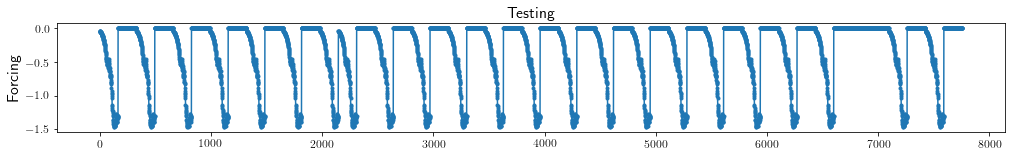

In [6]:
fig = plt.figure(figsize = (17,2))
plt.plot(y_test.values, '.-')
plt.ylabel("Forcing")
plt.title("Testing");

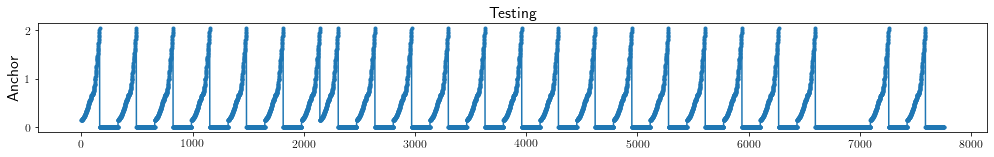

In [7]:
fig = plt.figure(figsize = (17,2))
plt.plot(y_anchor_test.values, '.-')
plt.ylabel("Anchor")
plt.title("Testing");

In [8]:
gamma = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]

target = params_climate["target"]
anchor = params_climate["anchor"]

### Cross validation

In [9]:
lambdaSel, mse_df, corr_pearson, mi, lambdasCV = anchor_regression.cross_validation_anchor_regression(
    modelsDataList,
    modelsInfoFrame,
    dict_models,
    params_climate,
    gamma,
    h_anchors,
    20,
    sel_method="MSE",
    display_CV_plot=False,
)

In [11]:
mse_test = np.zeros([len(lambdasCV), 1])
corr_pearson_test = np.zeros([len(lambdasCV), 1])
mi_test = np.zeros([len(lambdasCV), 1])

X, y, y_anchor, Xt, yt, yt_anchor, std_X_train = anchor_regression.standardize(dict_models)
X_PA, y_PA = anchor_regression.transformed_anchor_matrices(X, y, y_anchor, gamma, h_anchors)

for i in range(len(lambdasCV)):
    regr = linear_model.Ridge(alpha=X.shape[0] * lambdasCV[i] / 2)
    regr.fit(X_PA, y_PA)
    y_test_pred = regr.predict(Xt)
    residuals = (yt - y_test_pred).reshape(-1)

    mse_test[i] = np.mean((yt - y_test_pred) ** 2)
    corr_pearson_test[i] = np.round(np.corrcoef(np.transpose(yt_anchor), np.transpose(residuals))[0, 1], 2)
    mi_test[i] = np.round(mutual_info_regression(yt_anchor, residuals)[0], 2)

In [ ]:
""" Save CV values"""

filename = "./../output/data/CV_aer_co2_gamma100_square_noAhstd.pkl"
with open(filename, "rb") as f:
    pickle.dump([lambdaSel, mse_df, corr_pearson, mi, lambdasCV, mse_test, corr_pearson_test, mi_test], f)

In [ ]:
""" Read CV values"""

filename = "./../output/data/CV_aer_co2_gamma10000_square_Ahstd.pkl"
with open(filename, "rb") as f:
    lambdaSelMSE, mse_df, corr_pearson, mi, lambdasCV, mse_test, corr_pearson_test, mi_test = pickle.load(f)

NameError: name 'lambdaSelMSE' is not defined

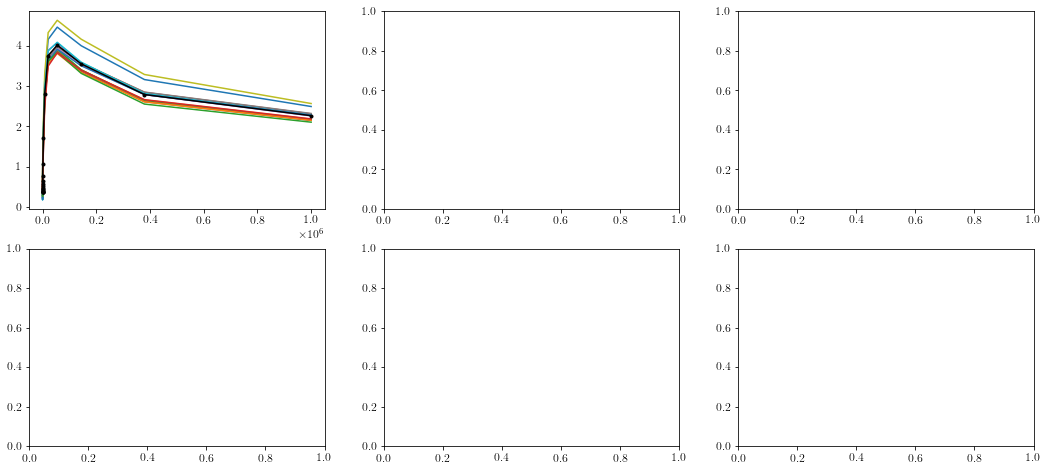

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

nbStd = np.array([1, 2, 3])
clr = ["r", "b", "k"]

for i in range(mse_df.shape[1] - 1):
    axes[0, 0].plot(mse_df.index, mse_df.iloc[:, i], label="_nolegend_")
axes[0, 0].plot(mse_df.index, mse_df.iloc[:, i + 1], "k.-")
axes[0, 0].axvline(lambdaSelMSE[0], ls="--", color="k", label="$\\lambda_{opt}$ = " + str(np.round(lambdaSelMSE[0], 2)))
for j in range(len(lambdaSelMSE) - 1):
    axes[0, 0].axvline(lambdaSelMSE[j + 1], color=clr[j], label="$\\lambda_{" + str(nbStd[j])
        + " SEM} $ = " + str(np.round(lambdaSelMSE[j + 1], 2)))
axes[0, 0].set_xscale("log")
axes[0, 0].set_yscale("log")
axes[0, 0].set_xlabel("$\\lambda$", fontsize=14)
axes[0, 0].set_ylabel("MSE", fontsize=14)
axes[0, 0].plot(lambdasCV, mse_test, 'r.-')

for j in range(corr_pearson.shape[1]):
    axes[0, 1].plot(lambdasCV, corr_pearson[:, j], label="_nolegend_")
axes[0, 1].plot(lambdasCV, np.mean(corr_pearson, axis = 1), "k.-")
axes[0, 1].set_xscale("log")
# axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel("$\\lambda$", fontsize=14)
axes[0, 1].set_ylabel("Corr", fontsize=14)
axes[0, 1].plot(lambdasCV, corr_pearson_test, 'r.-')
        
for j in range(mi.shape[1]):
    axes[0, 2].plot(lambdasCV, mi[:, j], label="_nolegend_")
axes[0, 2].plot(lambdasCV, np.mean(mi, axis = 1), "k.-")
axes[0, 2].set_xscale("log")
# axes[0, 2].set_yscale("log")
axes[0, 2].set_xlabel("$\\lambda$", fontsize=14)
axes[0, 2].set_ylabel("MI", fontsize=14);
axes[0, 2].plot(lambdasCV, mi_test, 'r.-')

lambdaSelPareto, pf_X, pf_Y, ind = anchor_regression.choose_lambda_pareto(mse_df.iloc[:,-1].values, 
                               np.mean(corr_pearson, axis = 1), lambdasCV, maxX=False, maxY=False, plot_var = False)

axes[1, 0].plot(mse_df.iloc[:, -1], np.abs(np.mean(corr_pearson, axis = 1)), ".-")
axes[1, 0].plot(pf_X[ind], pf_Y[ind], "r*")
axes[1, 0].set_xscale("log")
axes[1, 0].set_xlabel('MSE')
axes[1, 0].set_ylabel('Corr')        

axes[1, 1].plot(mse_df.iloc[:, -1], np.mean(mi, axis = 1), ".-")
axes[1, 1].set_xlabel('MSE')
axes[1, 1].set_ylabel('MI')        

axes[1, 2].plot(np.mean(corr_pearson, axis = 1), np.mean(mi, axis = 1), ".-")
axes[1, 2].set_xlabel('Corr')
axes[1, 2].set_ylabel('MI');

In [ ]:
lambdaSelMSE

In [ ]:
anchor_regression.anchor_regression(dict_models, gamma, h_anchors, lambdaSel[2], params_climate)

### Aggregating over multiple runs

In [ ]:
'''  Train files   '''
trainAll = []
for i in range(len(trainFiles)):
    for f in trainFiles[i]:
        mod = f.split("_")[2][:3]
        trainAll.append(mod)

# Option 1    
from collections import Counter
Counter(trainAll)

# Option 2
[[x, trainAll.count(x)] for x in set(trainAll)]

# '''   Test files   '''
# testAll = []
# for i in range(len(testFiles)):
#     for f in testFiles[i]:
#         mod = f.split("_")[2][:3]
#         testAll.append(mod)

# # Option 1    
# from collections import Counter
# Counter(testAll)

# # Option 2
# [[x, testAll.count(x)] for x in set(testAll)]

### Subagging

In [57]:
import pickle
filename = ("./../output/data/subagging_aerosols_co2_gamma_5000_square_noAhstd.pkl")
with open(filename, 'rb') as f:
    coefRaw_runs, mse_runs_df, corr_pearson_runs, mi_runs = pickle.load(f)

In [58]:
mse_runs_df

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Lambda selected
Run,,,,,,,,,,,,,,,,,,,,,
0,0.432318,0.409518,0.391468,0.378212,0.369948,0.367141,0.370399,0.380366,0.397823,0.423653,...,1.712045,2.766012,5.863350,14.331394,33.952952,69.744227,118.479271,166.873620,200.919844,3.039195
1,0.362134,0.344742,0.332131,0.324712,0.322804,0.326778,0.337226,0.354986,0.381163,0.417125,...,2.472362,4.534106,10.243507,24.119476,51.293585,91.740361,136.504939,173.701051,196.518148,1.610262
2,0.386486,0.370389,0.358268,0.349837,0.345483,0.346299,0.353573,0.368310,0.391076,0.422033,...,1.649611,2.700400,5.807636,14.226902,33.509778,68.435783,116.095962,164.138152,199.380740,1.610262
3,0.335516,0.317410,0.304606,0.297348,0.295633,0.299477,0.309210,0.325408,0.348580,0.378966,...,1.469376,2.197379,4.373963,10.587032,26.010925,56.939682,104.060274,156.701917,198.824309,1.610262
4,0.414710,0.398750,0.387381,0.380818,0.379519,0.384137,0.395739,0.415836,0.446107,0.488019,...,2.267338,3.735552,7.957792,18.947488,42.695456,82.592486,132.648106,179.090512,210.340517,1.610262
5,0.353733,0.337187,0.324746,0.316271,0.311969,0.312400,0.318321,0.330526,0.349832,0.377116,...,1.646589,2.545639,5.171325,12.459687,29.843983,62.887130,110.162560,159.637439,196.592324,1.610262
6,0.374790,0.353830,0.336619,0.323650,0.316189,0.315615,0.322823,0.338009,0.360793,0.390439,...,1.488492,2.212560,4.349747,10.400873,25.268871,54.669126,98.742425,147.293235,185.985408,1.610262
7,0.457343,0.435208,0.417917,0.406410,0.401785,0.405257,0.418215,0.442184,0.478593,0.528467,...,3.459455,6.419063,14.385918,32.769845,66.306230,112.324790,159.352981,195.684569,216.090542,1.610262
8,0.387661,0.367480,0.351660,0.340975,0.336236,0.338205,0.347657,0.365467,0.392477,0.429138,...,1.884740,2.926751,5.964202,14.198902,33.120248,67.454232,114.285037,161.408020,195.907706,1.610262


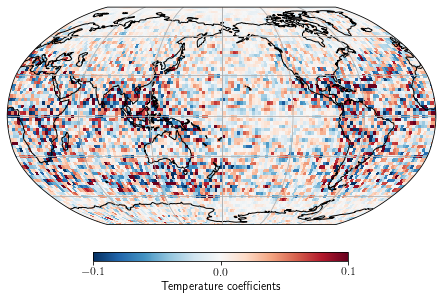

In [66]:
coefRaw_final = np.sum(coefRaw_runs, axis=0).reshape(-1, 1)
plots.plotMapCartopy(coefRaw.reshape(72,144), cLim=0.1, title=None, filename=None)

In [ ]:
plots.plotMapCartopy(coefRaw_runs[2,:].reshape(72,144), cLim=None, title=None, filename=None)